# Classification on MNIST Dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from helper_functions import test_classification, train

In [2]:
plt.style.use(
    [
        f"../mplstyles/{style}.mplstyle"
        for style in ["grid", "science", "notebook", "mylegend"]
    ]
)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device} device")

Using cpu device


In [4]:
SAVEFIG = True

## Load data

In [ ]:
training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

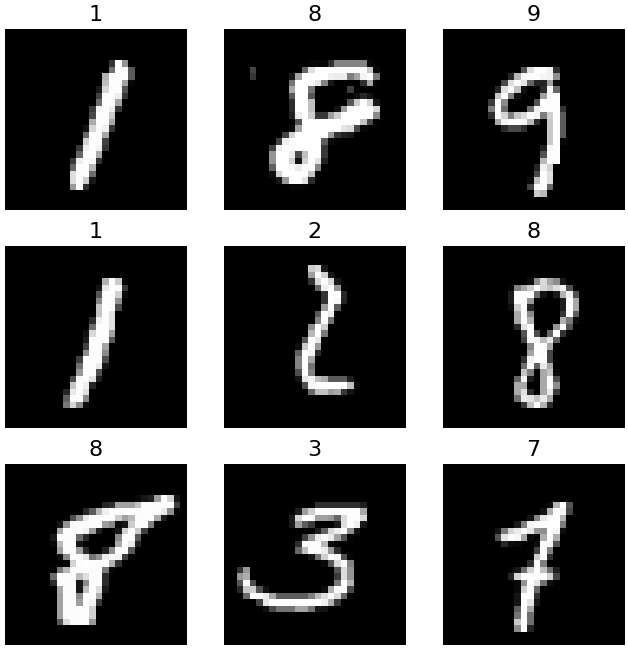

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
BATCH_SIZE = 64

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Training

In [8]:
def train_classification(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    learning_rate: float,
    epochs: int = 50,
) -> tuple[list[float], list[float], list[float]]:
    VERBOSE = False

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_losses: list[float] = []
    test_losses: list[float] = []
    accuracies: list[float] = []

    for epoch in range(epochs):
        # Halve learning rate after half epochs
        if epoch == int(epochs / 2):
            optimizer.param_groups[0]["lr"] = learning_rate / 2

        epoch_loss = train(train_dataloader, model, loss_fn, optimizer, verbose=VERBOSE)
        test_loss, accuracy = test_classification(
            test_dataloader, model, loss_fn, verbose=VERBOSE
        )

        print(
            f"Epoch {epoch + 1:2}/{epochs} - "
            f"Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss:>8f}"
        )

        train_losses.append(epoch_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
    print("Done!")

    return train_losses, test_losses, accuracies

In [9]:
EPOCHS = 50
LEARNING_RATE = 1e-2

### Linear model benchmark

In [10]:
linear_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 10),
    nn.Sigmoid(),
).to(device)

In [11]:
linear_train_losses, linear_test_losses, linear_accuracies = train_classification(
    linear_model, train_dataloader, test_dataloader, LEARNING_RATE, EPOCHS
)

Epoch  1/50 - Accuracy: 81.0%, Avg loss: 1.955827
Epoch  2/50 - Accuracy: 83.1%, Avg loss: 1.846277
Epoch  3/50 - Accuracy: 84.1%, Avg loss: 1.794403
Epoch  4/50 - Accuracy: 84.7%, Avg loss: 1.763176
Epoch  5/50 - Accuracy: 85.1%, Avg loss: 1.741775
Epoch  6/50 - Accuracy: 85.5%, Avg loss: 1.725981
Epoch  7/50 - Accuracy: 85.9%, Avg loss: 1.713620
Epoch  8/50 - Accuracy: 86.1%, Avg loss: 1.703596
Epoch  9/50 - Accuracy: 86.3%, Avg loss: 1.695328
Epoch 10/50 - Accuracy: 86.6%, Avg loss: 1.688162
Epoch 11/50 - Accuracy: 86.6%, Avg loss: 1.682019
Epoch 12/50 - Accuracy: 86.9%, Avg loss: 1.676649
Epoch 13/50 - Accuracy: 87.1%, Avg loss: 1.671844
Epoch 14/50 - Accuracy: 87.2%, Avg loss: 1.667574
Epoch 15/50 - Accuracy: 87.2%, Avg loss: 1.663687
Epoch 16/50 - Accuracy: 87.3%, Avg loss: 1.660171
Epoch 17/50 - Accuracy: 87.3%, Avg loss: 1.656914
Epoch 18/50 - Accuracy: 87.4%, Avg loss: 1.653943
Epoch 19/50 - Accuracy: 87.6%, Avg loss: 1.651234
Epoch 20/50 - Accuracy: 87.6%, Avg loss: 1.648665


### Neural Network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return self.sigmoid(logits)

In [13]:
model = NeuralNetwork(28 * 28, 10).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [14]:
train_losses, test_losses, accuracies = train_classification(
    model, train_dataloader, test_dataloader, LEARNING_RATE, EPOCHS
)

Epoch  1/50 - Accuracy: 57.6%, Avg loss: 2.260638
Epoch  2/50 - Accuracy: 71.7%, Avg loss: 2.100050
Epoch  3/50 - Accuracy: 76.1%, Avg loss: 1.860906
Epoch  4/50 - Accuracy: 76.3%, Avg loss: 1.769924
Epoch  5/50 - Accuracy: 79.2%, Avg loss: 1.718301
Epoch  6/50 - Accuracy: 80.9%, Avg loss: 1.681691
Epoch  7/50 - Accuracy: 82.2%, Avg loss: 1.657557
Epoch  8/50 - Accuracy: 82.8%, Avg loss: 1.641077
Epoch  9/50 - Accuracy: 83.2%, Avg loss: 1.629305
Epoch 10/50 - Accuracy: 82.8%, Avg loss: 1.619798
Epoch 11/50 - Accuracy: 84.0%, Avg loss: 1.611971
Epoch 12/50 - Accuracy: 84.4%, Avg loss: 1.605616
Epoch 13/50 - Accuracy: 84.5%, Avg loss: 1.599824
Epoch 14/50 - Accuracy: 84.5%, Avg loss: 1.594357
Epoch 15/50 - Accuracy: 84.4%, Avg loss: 1.589525
Epoch 16/50 - Accuracy: 84.2%, Avg loss: 1.585501
Epoch 17/50 - Accuracy: 84.0%, Avg loss: 1.582021
Epoch 18/50 - Accuracy: 84.4%, Avg loss: 1.578838
Epoch 19/50 - Accuracy: 83.9%, Avg loss: 1.576133
Epoch 20/50 - Accuracy: 84.0%, Avg loss: 1.573544


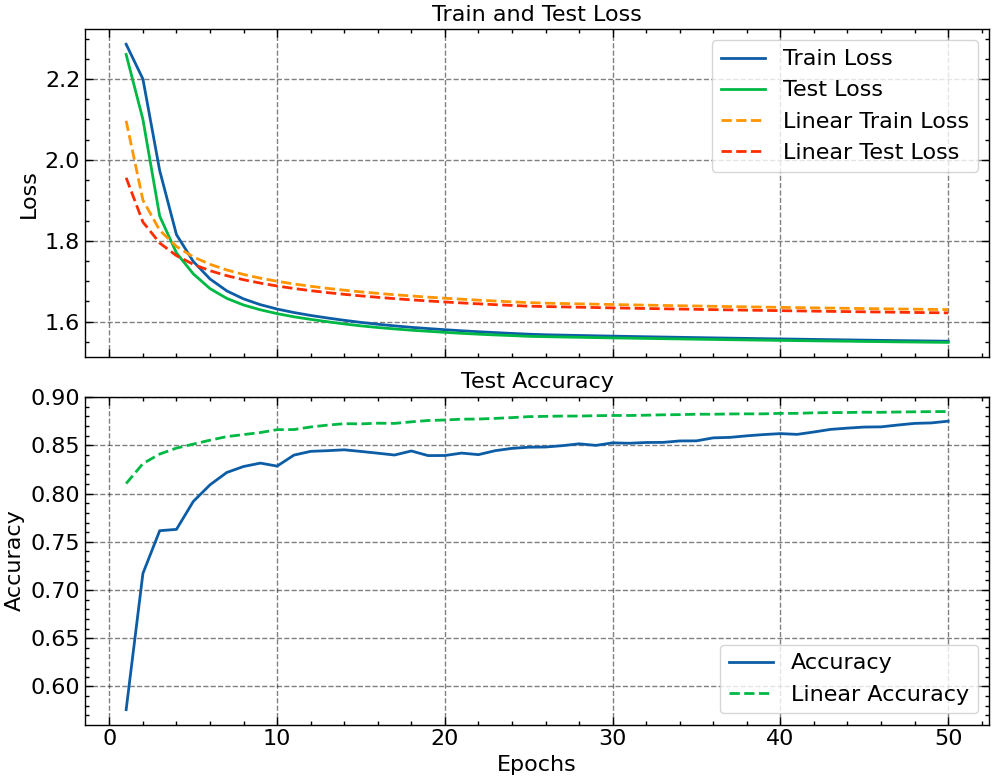

In [29]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax = axes[0]
ax.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
ax.plot(range(1, EPOCHS + 1), test_losses, label="Test Loss")
ax.plot(
    range(1, EPOCHS + 1), linear_train_losses, label="Linear Train Loss", linestyle="--"
)
ax.plot(
    range(1, EPOCHS + 1), linear_test_losses, label="Linear Test Loss", linestyle="--"
)

ax.set_title("Train and Test Loss")
ax.set_ylabel("Loss")

ax.legend()

ax = axes[1]
ax.plot(range(1, EPOCHS + 1), accuracies, label="Accuracy")
ax.plot(
    range(1, EPOCHS + 1), linear_accuracies, label="Linear Accuracy", linestyle="--"
)

ax.set_title("Test Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

ax.legend()

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig("./images/class_loss_acc.png", dpi=200)

In [16]:
def get_num_classes(dataloader: DataLoader) -> int:
    num_classes = 0
    for _, labels in dataloader:
        num_classes = max(num_classes, labels.max().item() + 1)
    return num_classes


def confusion_matrix(model: nn.Module, test_dataloader: DataLoader) -> torch.Tensor:
    num_classes = get_num_classes(test_dataloader)
    conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            for t, p in zip(labels, preds):
                conf_matrix[t, p] += 1

    return conf_matrix

In [17]:
linear_conf_matrix = confusion_matrix(linear_model, test_dataloader)
conf_matrix = confusion_matrix(model, test_dataloader)

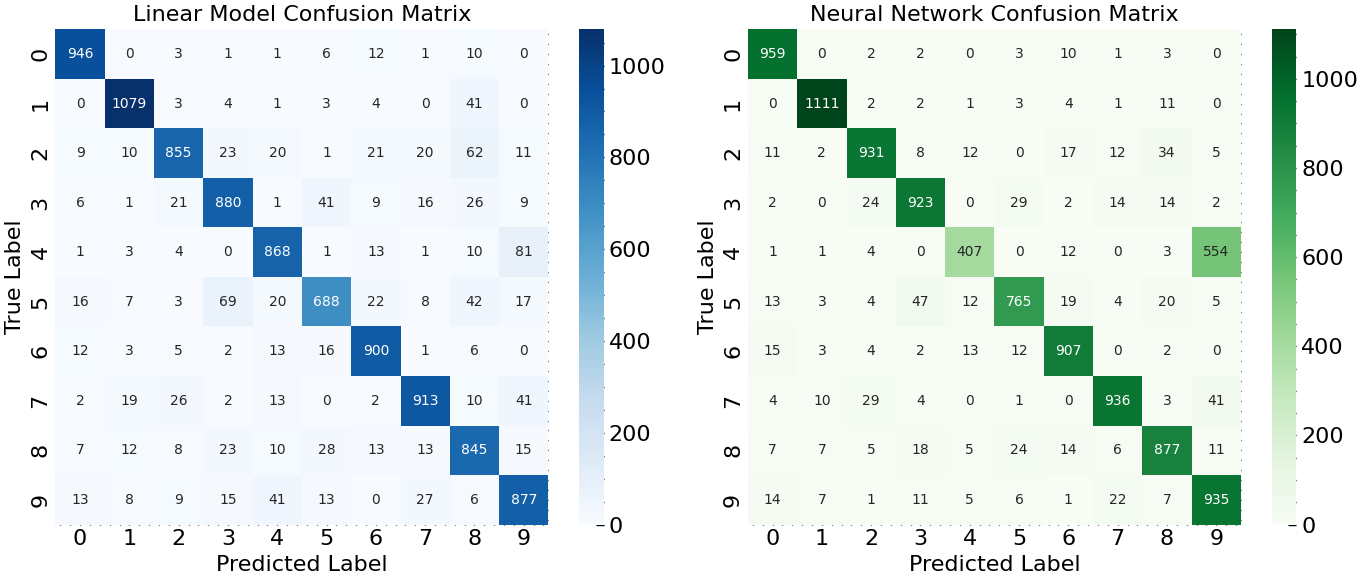

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
sns.heatmap(linear_conf_matrix, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Linear Model Confusion Matrix")

ax = axes[1]
sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax, cmap="Greens")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Neural Network Confusion Matrix")

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig("./images/class_conf_matrix.png", dpi=200)